<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/gpax_simpleGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian process in a fully Bayesian mode

This notebook demonstrates an application of the Gaussian process class in GPax package to a 1D problem.

*Prepared by Maxim Ziatdinov (2024)*

Gaussian process (GP) is a powerful tool for reconstructing with quantified uncertainty an unknown  (“black-box”) function  over a low-dimensional parameter space from sparse measurements. Formally, given a set of observed data points $(x_i, y_i)_{i=1, ..., N}$ and assuming normally distributed observation noise $𝜀$, the GP aims to reconstruct the function $f(x)$ such as $y_i= f(x_i) + 𝜀_i$, with $f$ sampled from a multivariate normal prior distribution, $f ∼ MVN(0; K(x_i, x_j))$. The functional form of the kernel $K$ is chosen prior to the experiment, and its hyperparameters are inferred from the observations using either Markov chain Monte Carlo methods or stochastic variational inference.

## Install & Import

Install GPax package:

In [ ]:
!pip install -q gpax

Import needed packages:

In [2]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()  # enable double precision

## Simple Problem

### Create data

Generate some noisy observations:

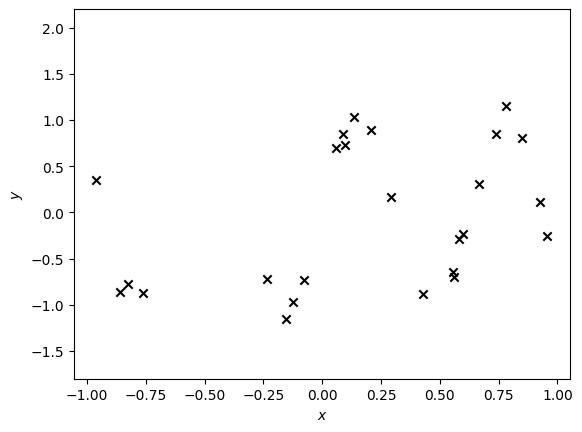

In [3]:
np.random.seed(0)

NUM_INIT_POINTS = 25 # number of observation points
NOISE_LEVEL = 0.1 # noise level

# Generate noisy data from a known function
f = lambda x: np.sin(10*x)

X = np.random.uniform(-1., 1., NUM_INIT_POINTS)
y = f(X) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS)

# Plot generated data
plt.figure(dpi=100)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.scatter(X, y, marker='x', c='k', zorder=1, label='Noisy observations')
plt.ylim(-1.8, 2.2);

### Standard GP

Next, we initialize and train a GP model. We are going to use an RBF kernel, $k_{RBF}=𝜎exp(-\frac{||x_i-x_j||^2}{2l^2})$, which is a "go-to" kernel functions in GP.

In [4]:
# Get random number generator keys for training and prediction
key1, key2 = gpax.utils.get_keys()

# Initialize model
gp_model = gpax.ExactGP(1, kernel='RBF')
# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(key1, X, y, num_chains=1)

sample: 100%|██████████| 4000/4000 [00:10<00:00, 375.60it/s, 7 steps of size 5.52e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.17      0.03      0.17      0.12      0.23   1017.15      1.00
    k_scale      1.25      0.90      0.99      0.29      2.33    850.74      1.00
      noise      0.03      0.02      0.03      0.01      0.06   1039.66      1.00



Now let's use our trained model to obtain a probabilistic prediction of function values on new ("test") data. In the fully Bayesian mode, we get a pair of predictive mean and covariance, $𝜇_*^i$ and $𝛴^i_*$, for each *i*-th HMC sample with kernel parameters $𝜃$,

$$𝜇_*^i=K(X_*,X|𝜃^i)K(X,X|𝜃^i)^{-1}y$$
$$𝛴^i_*=K(X_*,X_*|𝜃^i)-K(X_*,X|𝜃^i)K(X,X|𝜃^i)^{-1}K(X,X_*|𝜃^i)$$

The ```.predict()``` method returns the center of the mass of all the predictive means,

$$𝜇^{post}_*= \frac{1}{L} ∑_{i=1}^L 𝜇_*^i,$$

which corresponds to the ```posterior_mean``` in the code cell below, and
samples

$$f_*^i∼MVNormal(𝜇^i_*, 𝛴^i_*)$$

from multivariate normal distributions for all the pairs of predictive means and covariances (```f_samples``` in the code cell below). Note that model noise is absorbed into the kernel computation function.

In [5]:
# Prepare test inputs
X_test = np.linspace(-1, 1, 100)
# Get the GP prediction. Here n stands for the number of samples from each MVNormal distribution
# (the total number of MVNormal distributions is equal to the number of HMC samples)
posterior_mean, f_samples = gp_model.predict(key2, X_test, n=200)

Plot the obtained results:

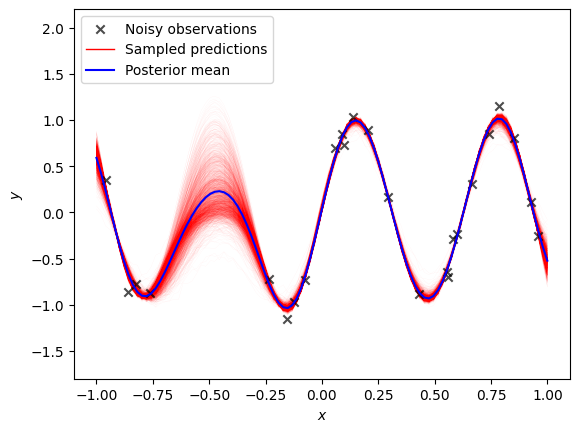

In [6]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in f_samples:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_test, f_samples[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, posterior_mean, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.legend(loc='upper left')
l.set_alpha(0)
ax.set_ylim(-1.8, 2.2);

We can see there is a relatively large uncertainty - defined by the dispersion in sampled predictions - in GP prediction between -0.75 and -0.25 where no measurements are available. It is also common in the GP literature to draw the GP uncertainty as a $2\sigma$ shaded region around the GP posterior mean:

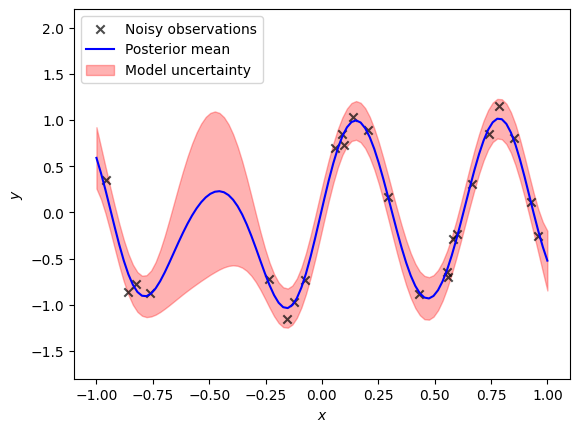

In [7]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=2, label="Noisy observations", alpha=0.7)
ax.plot(X_test, posterior_mean, lw=1.5, zorder=2, c='b', label='Posterior mean')
ax.fill_between(X_test,
                posterior_mean - f_samples.std(axis=(0,1)),
                posterior_mean + f_samples.std(axis=(0,1)),
                color='r', alpha=0.3, label="Model uncertainty")
ax.legend(loc='upper left')
ax.set_ylim(-1.8, 2.2);

## (Slightly) More Diffcult Problem

Now let's explore how GP performs with more complex data and how customization of GP priors can help obtaining a more accurate posterior predictive distribution.

### Generate new data

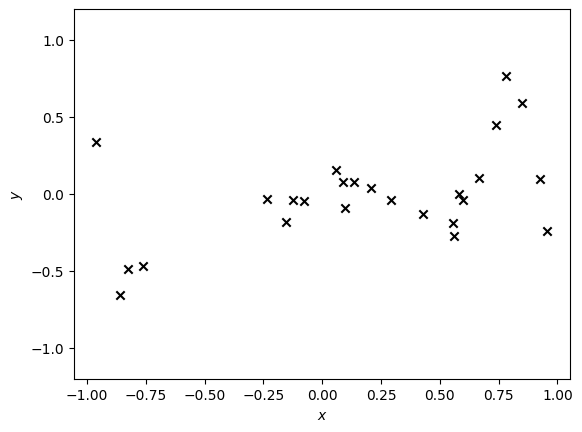

In [8]:
np.random.seed(0)

NUM_INIT_POINTS = 25 # number of observation points
NOISE_LEVEL = 0.1 # noise level

# Generate noisy data from a known function
f = lambda x: np.sin(10*x) * x**2

X = np.random.uniform(-1., 1., NUM_INIT_POINTS)
y = f(X) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS)

# Plot generated data
plt.figure(dpi=100)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.scatter(X, y, marker='x', c='k', zorder=1, label='Noisy observations')
plt.ylim(-1.2, 1.2);

### Standard GP

First, we initialize and train a standard GP model, same as before.

In [9]:
# Get random number generator keys for training and prediction
key1, key2 = gpax.utils.get_keys()

# Initialize model
gp_model = gpax.ExactGP(1, kernel='RBF')

# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(key1, X, y, num_chains=1)

sample: 100%|██████████| 4000/4000 [00:05<00:00, 706.59it/s, 15 steps of size 2.69e-01. acc. prob=0.78]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.16      1.94      0.25      0.06      3.04    367.85      1.00
    k_scale      0.45      0.46      0.30      0.03      0.93    408.14      1.00
      noise      0.07      0.05      0.07      0.01      0.13    189.70      1.00



Make a prediction with the trained model:

In [10]:
X_test = np.linspace(-1, 1, 100)

posterior_mean, f_samples = gp_model.predict(key2, X_test, n=200)

Plot the obtained results:

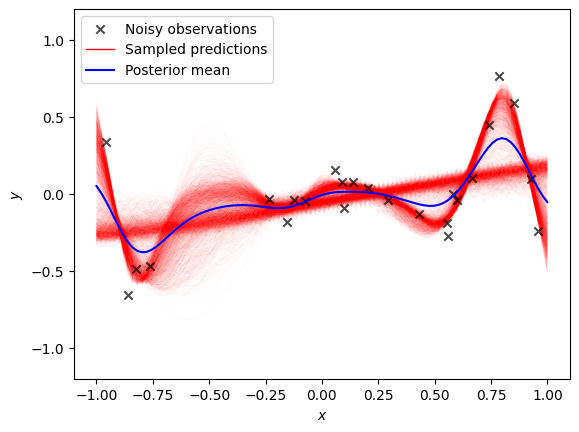

In [11]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in f_samples:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_test, f_samples[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, posterior_mean, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.legend(loc='upper left')
l.set_alpha(0)
ax.set_ylim(-1.2, 1.2);

Each red line represents one possible function that the GP has determined could plausibly fit the data. We can see that a subset of solutions correspond to a quasi-linear fit, indicating that the GP, while considering the noise in the data, has found that a simpler linear model cannot be ruled out. However, there is also a sizable collection of sampled predictions that show a more complex, non-linear behavior. The solid blue line is the center of the mass of the predictive distributions of the GP.


Same as before, we can plot the GP uncertainty as a $2\sigma$ shaded region around the GP posterior mean. We also added the ground truth to help judging the quality of the prediction.

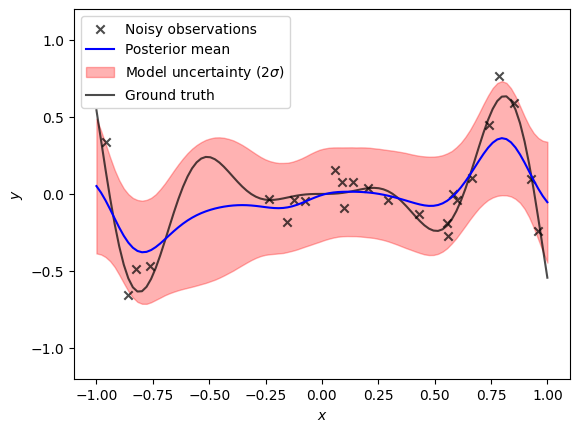

In [12]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=2, label="Noisy observations", alpha=0.7)
ax.plot(X_test, posterior_mean, lw=1.5, zorder=2, c='b', label='Posterior mean')
ax.fill_between(X_test,
                posterior_mean - f_samples.std(axis=(0,1)),
                posterior_mean + f_samples.std(axis=(0,1)),
                color='r', alpha=0.3, label="Model uncertainty (2$\sigma$)")
ax.plot(X_test, f(X_test), color='k', alpha=0.7, zorder=1, label='Ground truth')
ax.legend(loc='upper left')
ax.set_ylim(-1.2, 1.2);

### GP with custom kernel priors

We next demonstrate how using a more narrow prior over the kernel lengthscale can result in a more accurate prediction.

Thus far, we have used a default $LogNormal(0, 1)$ priors for all the GP model parameters, including kernel lengthscale. However, it usually makes sense to use custom priors if one possesses prior knowledge regarding the approximate characteristic lengthscale of the phenomenon of interest.

Let's define a custom prior distribution over the kernel lengthscale

In [13]:
lengthscale_prior_dist = gpax.utils.gamma_dist(2, 5)

Generally, it is a good idea to visualize a distribution before using it as a prior. GPax has a convenient utility function for this:

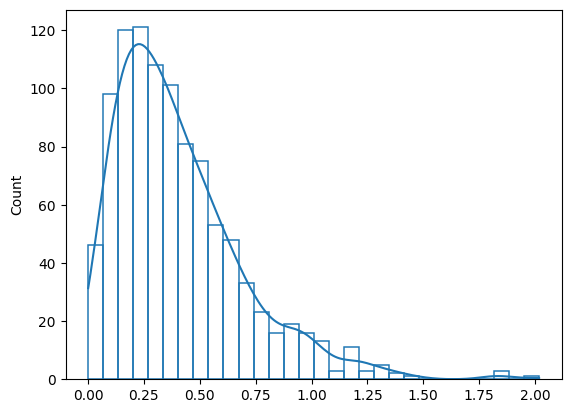

In [14]:
gpax.utils.dviz(lengthscale_prior_dist)

Re-run GP model training using the custom prior over the kernel lengthscale:

In [15]:
# Get random number generator keys for training and prediction
key1, key2 = gpax.utils.get_keys()

# Initialize model
gp_model = gpax.ExactGP(1, kernel='RBF', lengthscale_prior_dist=lengthscale_prior_dist)

# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(key1, X, y, num_chains=1)

sample: 100%|██████████| 4000/4000 [00:06<00:00, 647.22it/s, 7 steps of size 4.26e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.18      0.16      0.15      0.07      0.26    419.71      1.00
    k_scale      0.32      0.31      0.23      0.04      0.63    978.53      1.00
      noise      0.04      0.03      0.04      0.01      0.08    614.46      1.00



Make a prediction:

In [16]:
posterior_mean, f_samples = gp_model.predict(key2, X_test, n=200)

Plot results:

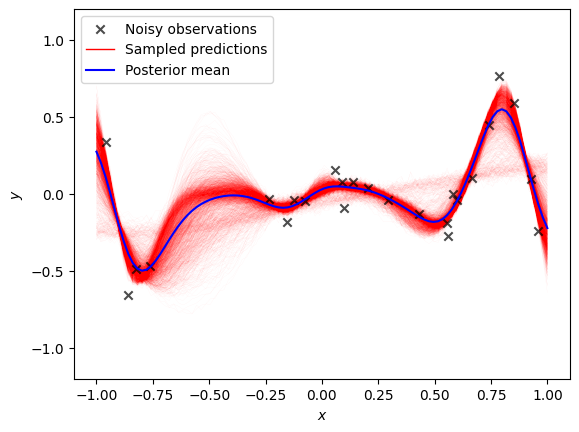

In [18]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in f_samples:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_test, f_samples[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, posterior_mean, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.legend(loc='upper left')
l.set_alpha(0)
ax.set_ylim(-1.2, 1.2);

The result reveals a markedly reduced prominence of the quasi-linear subset among the sampled predictions. The GP has also become more responsive to nearby data points, capturing more of the local structure of the data.


Plot the GP uncertainty as a $2\sigma$ shaded region around the GP posterior mean and overlay with the ground truth:

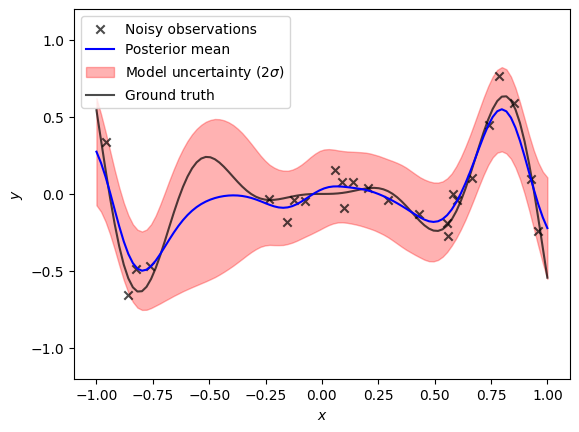

In [19]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=2, label="Noisy observations", alpha=0.7)
ax.plot(X_test, posterior_mean, lw=1.5, zorder=2, c='b', label='Posterior mean')
ax.fill_between(X_test,
                posterior_mean - f_samples.std(axis=(0,1)),
                posterior_mean + f_samples.std(axis=(0,1)),
                color='r', alpha=0.3, label="Model uncertainty (2$\sigma$)")
ax.plot(X_test, f(X_test), color='k', alpha=0.7, zorder=1, label='Ground truth')
ax.legend(loc='upper left')
ax.set_ylim(-1.2, 1.2);